In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [50]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



In [51]:
import numpy as np

def bootstrap_mean_and_std_error(data, num_samples=1000):
    """
    Calculates the bootstrap mean and the bootstrap standard error of the mean.

    Args:
        data (array-like): A list or NumPy array of your data points (e.g., 100 fidelities).
        num_samples (int): The number of bootstrap samples to generate.

    Returns:
        tuple: A tuple containing (bootstrap_mean, bootstrap_standard_error).
    """
    n_observations = len(data)
    bootstrap_means = []
    
    for _ in range(num_samples):
        # Create a bootstrap sample by sampling with replacement
        resample = np.random.choice(data, size=n_observations, replace=True)
        
        # Calculate the mean of the bootstrap sample and store it
        bootstrap_means.append(np.mean(resample))
        
    # The bootstrap estimate of the mean is the average of the bootstrap means
    bootstrap_mean_estimate = np.mean(bootstrap_means)
    
    # The bootstrap estimate of the standard error is the standard deviation of the bootstrap means
    bootstrap_std_error_estimate = np.std(bootstrap_means, ddof=1)
    
    return bootstrap_mean_estimate, bootstrap_std_error_estimate




In [53]:
# Define parameter ranges
ramp_times = [40, 80, 120, 160, 210]
A_values = [1e-3*2*np.pi, 2.5e-3*2*np.pi, 5e-3*2*np.pi]

def compute_fidelity_drag(ramp_time, A):

    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    # Setup parameters
    time_points = np.linspace(0, ramp_time, 1000)
    T = 5 * ramp_time
    gamma = 0
    # Solver options and collapse operators
    opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
    
    # Get operators and functions
    sds, sop, H_control, H0 = sim.operators()
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.A_function(freq, ramp_time, T, sim.A)
    phi_func = sim.phi_function(freq, ramp_time, T, sim.A)

    # Get Floquet states and projectors
    floquet_states, sigmax, sigmas = sim.kick_and_sigmax(ramp_time)
    projectors = sim.get_projector(floquet_states)

    # Define Hamiltonian terms
    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))

    # Run simulations for both initial states
    avg_values = []
    values = []
    for idx in [0, 1]:
        def run_single_trajectory(traj_idx):
            traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
            noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
            H = [H0, [sds, noise_term], [H_control, drive_term]]
            result = qt.mesolve(H, qt.basis(6, idx), time_points, c_ops, options=opts)
            return result.states[-1]
        
        # Parallelize over all trajectories using joblib
        from joblib import Parallel, delayed
        final_states = Parallel(n_jobs=-1)(delayed(run_single_trajectory)(traj_idx) for traj_idx in range(sim.num_realizations))
        
        # Compute expectation values for each final state
        values.append([qt.expect(projectors[idx], state) for state in final_states])
        # Compute average final state
        final_state = sum(final_states) / len(final_states)
        
        avg_values.append(qt.expect(projectors[idx], final_state))
    avg_value0, avg_value1 = avg_values
    # Compute fidelity for each trajectory
    fidelities = []
    for traj_idx in range(sim.num_realizations):
        value0 = values[0][traj_idx]
        value1 = values[1][traj_idx]
        fidelity = (np.sqrt(value0) + np.sqrt(value1))**2/4
        fidelities.append(fidelity)
    # Compute infidelity for each trajectory
    infidelities = 1 - np.array(fidelities)
    mean_infid, std_error_infid = bootstrap_mean_and_std_error(infidelities, num_samples=10000)
    return mean_infid, std_error_infid

def compute_fidelity(ramp_time, A):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    # Setup parameters
    time_points = np.linspace(0, ramp_time, 1000)
    T = 5 * ramp_time
    gamma = 1 / (2e4)

    # Get operators and functions
    sds, sop, H_control, H0 = sim.operators()
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.I_control(ramp_time, T, A)

    # Get Floquet states and projectors
    floquet_states, sigmax, sigmas = sim.kick_and_sigmax(ramp_time)
    projectors = sim.get_projector(floquet_states)

    # Define Hamiltonian terms
    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t)

    # Solver options and collapse operators
    opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]

    # Run simulations for both initial states
    avg_values = []
    values = []
    for idx in [0, 1]:
        def run_single_trajectory(traj_idx):
            traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
            noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
            H = [H0, [sds, noise_term], [H_control, drive_term]]
            result = qt.mesolve(H, qt.basis(6, idx), time_points, c_ops, options=opts)
            return result.states[-1]
        
        # Parallelize over all trajectories using joblib
        from joblib import Parallel, delayed
        final_states = Parallel(n_jobs=-1)(delayed(run_single_trajectory)(traj_idx) for traj_idx in range(sim.num_realizations))
        
        # Compute expectation values for each final state
        values.append([qt.expect(projectors[idx], state) for state in final_states])
        # Compute average final state
        final_state = sum(final_states) / len(final_states)
        
        avg_values.append(qt.expect(projectors[idx], final_state))
    avg_value0, avg_value1 = avg_values
    # Compute fidelity for each trajectory
    fidelities = []
    for traj_idx in range(sim.num_realizations):
        value0 = values[0][traj_idx]
        value1 = values[1][traj_idx]
        fidelity = (np.sqrt(value0) + np.sqrt(value1))**2/4
        fidelities.append(fidelity)
    # Compute infidelity for each trajectory
    infidelities = 1 - np.array(fidelities)
    mean_infid, std_error_infid = bootstrap_mean_and_std_error(infidelities, num_samples=10000)
    return mean_infid, std_error_infid

In [ ]:
# Run for loop for different ramp_time and A values
results = []
std_errors = []
for ramp_time in ramp_times:
    for A in A_values:
        avg, std = compute_fidelity_drag(ramp_time, A)
        results.append(avg)
        std_errors.append(std)
        print(f"Ramp time: {ramp_time}, A: {A/(2*np.pi):.3e}, Infidelity: {avg:.6e} ± {std:.6e}")

# Create infidelity matrix and std error matrix
infidelity_matrix = np.array(results).reshape(len(ramp_times), len(A_values))
std_error_matrix = np.array(std_errors).reshape(len(ramp_times), len(A_values))

print(f"\nRamp times: {ramp_times}")
print(f"A values: {[A/(2*np.pi) for A in A_values]}")
print(f"Infidelity matrix shape: {infidelity_matrix.shape}")
print(f"Infidelity matrix:\n{infidelity_matrix}")
print(f"Std error matrix:\n{std_error_matrix}")

Ramp time: 40, A: 1.000e-03, Infidelity: 6.082375e-04 ± 4.285128e-06
Ramp time: 40, A: 2.500e-03, Infidelity: 3.547673e-04 ± 9.384344e-06
Ramp time: 40, A: 5.000e-03, Infidelity: 2.177109e-04 ± 6.991811e-06
Ramp time: 80, A: 1.000e-03, Infidelity: 3.372157e-04 ± 1.059744e-05


In [63]:
# Sweep ramp time for a specific A value
A_fixed = 5e-3 * 2 * np.pi
ramp_times = [40, 80, 120, 160, 210]

print(f"Sweeping ramp time for fixed A = {A_fixed/(2*np.pi):.3e}")
sweep_results = []
sweep_std_errors = []

for ramp_time in ramp_times:
    avg, std = compute_fidelity(ramp_time, A_fixed)
    sweep_results.append(avg)
    sweep_std_errors.append(std)
    print(f"Ramp time: {ramp_time:.1f} ns, Infidelity: {avg:.6e} ± {std:.6e}")

# Add sweep results to the main results
results.extend(sweep_results)
std_errors.extend(sweep_std_errors)

print(f"\nSweep completed. Added {len(sweep_results)} results to main results array.")
print(f"Total results: {len(results)}")


Sweeping ramp time for fixed A = 5.000e-03
Ramp time: 40.0 ns, Infidelity: 1.246013e-02 ± 1.539566e-04
Ramp time: 80.0 ns, Infidelity: 1.764777e-04 ± 6.408512e-06
Ramp time: 120.0 ns, Infidelity: 8.271178e-05 ± 3.575090e-06
Ramp time: 160.0 ns, Infidelity: 9.651991e-05 ± 4.707361e-06
Ramp time: 210.0 ns, Infidelity: 1.043008e-04 ± 4.614505e-06

Sweep completed. Added 5 results to main results array.
Total results: 25


Plot data saved to 'preparation_fidelity_data.npz'


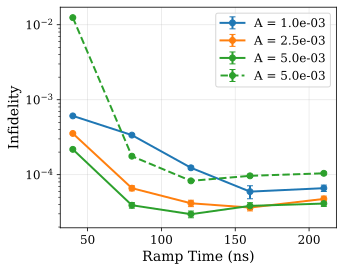

In [68]:
# Save plot data for easy export to other files
plot_data = {
    'ramp_times': ramp_times,
    'A_values': A_values,
    'A_values_normalized': [A/(2*np.pi) for A in A_values],
    'infidelity_matrix': infidelity_matrix,
    'std_error_matrix': std_error_matrix,
    'sweep_results': sweep_results,
    'sweep_std_errors': sweep_std_errors,
    'A_fixed': A_fixed,
    'A_fixed_normalized': A_fixed/(2*np.pi)
}

# Save data to numpy file
np.savez('preparation_fidelity_data.npz', **plot_data)
print("Plot data saved to 'preparation_fidelity_data.npz'")

# Create a figure for plotting infidelity vs ramp_time for different A values
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Set font sizes for paper-quality figure
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
    'mathtext.fontset': 'stix'
})

# Plot infidelity for each A value
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i, A in enumerate(A_values):
    infidelity = infidelity_matrix[:, i]
    std_error = std_error_matrix[:, i]
    ax.errorbar(ramp_times, infidelity, yerr=std_error, fmt='o-', 
                label=f'A = {A/(2*np.pi):.1e}', linewidth=2, markersize=6, capsize=3,
                color=colors[i % len(colors)])
ax.errorbar(ramp_times, sweep_results, yerr=sweep_std_errors, fmt='o--', 
                label=f'A = {A/(2*np.pi):.1e}', linewidth=2, markersize=6, capsize=3,color=colors[2])
ax.set_xlabel('Ramp Time (ns)')
ax.set_ylabel('Infidelity')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
# Save the plot in tight form as a PDF with the name 'preparation_fidelity.pdf'
plt.savefig('preparation_fidelity.pdf', bbox_inches='tight')
plt.show()

In [7]:
def compute_dephasing_rate(A):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)

    # Define parameter ranges
    gamma = 1/(2e4)
    sds, sop, H_control, H0 = sim.operators()
    sim_time = 10000
    time_points = np.linspace(0, sim_time, 20000)
    floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
    get_projector = sim.get_projector
    floquet_ground = floquet_states[:,0]
    floquet_excited = floquet_states[:,1]
    initial_state = qt.Qobj(floquet_excited)
    projectors = get_projector(floquet_states)

    L = np.sqrt(gamma) * qt.Qobj(sop)
    c_ops = [L]

    drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
    H = [H0, [H_control, drive_term]]
    opts = {'nsteps': t_max, 'atol': 1e-14, 'rtol': 1e-14}
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)
    # Compute time-dependent projectors and expectation values
    avg_values = np.zeros(len(time_points))
    for j, t in enumerate(time_points):
        floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
        projectors = get_projector(floquet_states)
        P00 = projectors[0]
        avg_values[j] = qt.expect(P00, result.states[j])
    def fit1(t, T1):
        return 1 - np.exp(-t / T1)
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(fit1, time_points, np.array(avg_values))
    T1_fitted = popt[0]

    initial_state = 1/np.sqrt(2)*(qt.Qobj(floquet_excited) + qt.Qobj(floquet_ground))
    result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)

    for j, t in enumerate(time_points):
        floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
        projectors = get_projector(floquet_states)
        P00 = projectors[0]
        avg_values[j] = qt.expect(qt.Qobj(sigmax), result.states[j])
    def T2fit(t, T2):
        return np.exp(-t / T2) * np.cos(sim.sc.fit_omega * t)

    popt, pcov = curve_fit(T2fit, time_points, avg_values, p0=[1e6])
    T2_fit = popt[0]
    dephasing_rate1 = 1/T2_fit - 1/T1_fitted/2
    dephasing_rate2 =  gamma*(((2*A/(0.1*2*np.pi))**(2/3)/4)**2 + (0.01*(0.1*2*np.pi/(2*A))**(1/3))**2/2)
    return dephasing_rate1, dephasing_rate2


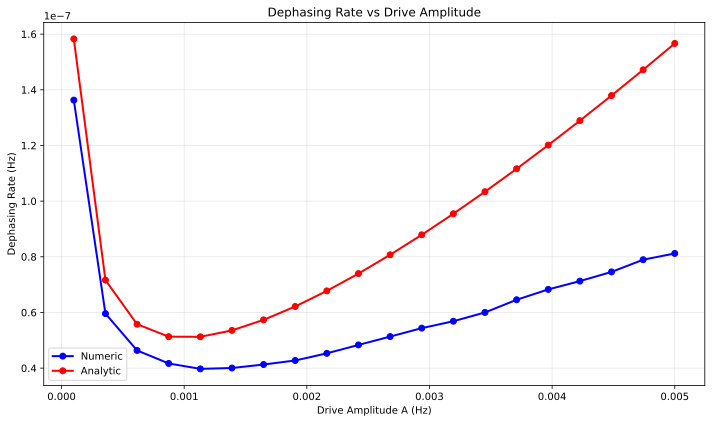

In [8]:
A_values = np.linspace(0.1e-3, 5e-3, 20) * 2 * np.pi
from joblib import Parallel, delayed

# Compute dephasing rates for all A values in parallel
dephasing_rates = Parallel(n_jobs=-1)(delayed(compute_dephasing_rate)(A) for A in A_values)

# Separate the two dephasing rates
dephasing_rates_numeric = [rate[0] for rate in dephasing_rates]
dephasing_rates_analytic = [rate[1] for rate in dephasing_rates]

# Plot dephasing rate vs A
plt.figure(figsize=(10, 6))
plt.plot(A_values / (2 * np.pi), dephasing_rates_numeric, 'bo-', linewidth=2, markersize=6, label='Numeric')
plt.plot(A_values / (2 * np.pi), dephasing_rates_analytic, 'ro-', linewidth=2, markersize=6, label='Analytic')
plt.xlabel('Drive Amplitude A (Hz)')
plt.ylabel('Dephasing Rate (Hz)')
plt.title('Dephasing Rate vs Drive Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()